# F2Heal - PAC analysis



## Intro

In this notbook we try to reproduce the results of Swan et al. in "Elevated Synchrony in Parkinson's Disease Detected with
Electroencephalography" using Python.

The following domain specific Python libraries are used:
* [MNE-Python](https://mne.tools/)
* [pactools](https://github.com/pactools/pactools)
* [openneuro-py](https://pypi.org/project/openneuro-py/)

The following general purpose libraries are used:
* [NumPy](https://numpy.org/)
* [MatplotLib](https://matplotlib.org/)

We will use the San Diego dataset [published on OpenNeuro](https://openneuro.org/datasets/ds002778)

## Preparation


Install required python packages for this notebook evironment:

In [1]:
%pip install mne mne_bids pactools openneuro-py autoreject ipympl

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib widget

## Pyhton script

### Setting the scene

As usual, we like it open source!

In [3]:
# SPDX-License-Identifier: AGPL-3.0-or-later 


The Python script starts by importing all required libraries

In [4]:
import mne
import mne_bids
import openneuro

import autoreject

import numpy as np
import pactools
import matplotlib.pyplot as plt

We introduce a configurable parameter. Change the verbose parameter to `False` for less output.

In [5]:
verbose = True

Next, we'll define a class with configuration data describing the OpenNeuro dataset that will be used from here on.

In [6]:
class ONDataset:
    """
    Open EEG dataset from OpenNeuro
    Parkinson's EEG dataset <https://openneuro.org/datasets/ds002778
    """
    dataset = 'ds002778'
    bids_root = "/tmp/mne"
    datatype = 'eeg'
    task = 'rest'
    suffix = 'eeg'


Next, we'll also define a class with configuration parameters relevant for the PAC generation. These variables can be modified.

The variable `low_fq_range` defines the frequency range for which the phase is extracted and will become the X-axis of the comodulogram.

The variable `high_fq_range` defines the frequency range for which the amplitude component is extracted and will become the Y-axis of the comodulogram.

The syntax of the Numpy linspace function is: `np.linspace(<lower freq in Hz>, <upper freq in Hz>, <number of intervals>)`. The `<number of intervals>` determine the resolution of the comodulogram.

The variable `method` specifies the PAC calculation method. Valid methods are:  `'tort', 'penny', 'vanwijk', 'duprelatour', 'colgin', 'sigl', 'bispectrum'`

Swan et al. have used the equivalent of the `'tort'` method in MATLAB. This method does not produce similar results in MNE-Python. The method `'duprelatour'` does. See [this Github issue](https://github.com/pactools/pactools/issues/33) for more details.

In [7]:
class PACSettings:
    low_fq_range = np.linspace(13,50,150)
    low_fq_width = 2
    high_fq_range= np.linspace(50,200,150)
    high_fq_width= 4
    method= 'duprelatour'

    def create_Comodulogram(fs):
        return pactools.Comodulogram (fs=fs,
                                      low_fq_range=PACSettings.low_fq_range,
                                      low_fq_width=PACSettings.low_fq_width,
                                      high_fq_range=PACSettings.high_fq_range,
                                      high_fq_width=PACSettings.high_fq_width,
                                      method=PACSettings.method,
                                      progress_bar=verbose)

### Loading the OpenNeuro data

We need to pick a valid subject from the OpenNeuro dataset. You can pick an ID from: 3, 5, 6, 9, 11, 12, 13, 14, 16, 17, 19, 22, 23, 26, 28

In [8]:
subject = "pd6"

Next, we'll download the relevant EEG session for this subject from OpenNeuro. You might need to restart this step a second time if it fails at first.

In [9]:
def fetch_raw(subject, session):

    openneuro.download(dataset=ONDataset.dataset, target_dir=ONDataset.bids_root, include=[f"sub-{subject}"])
    bids_path = mne_bids.BIDSPath(root=ONDataset.bids_root,
                         task=ONDataset.task, suffix=ONDataset.suffix,
                         datatype=ONDataset.datatype, session=session,
                         subject=subject )

    raw = mne.io.read_raw_bdf(bids_path, verbose=verbose, preload=True)

    return raw

raw_on = fetch_raw(subject, 'on')


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds002778 …


📁 Traversing directories for ds002778 : 0 entities [00:00, ? entities/s]

📥 Retrieving up to 19 files (5 concurrent downloads). 
✅ Finished downloading ds002778.
 
🧠 Please enjoy your brains.
 
Extracting EDF parameters from /tmp/mne/sub-pd6/ses-on/eeg/sub-pd6_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 147967  =      0.000 ...   288.998 secs...


### Data inspection (optional)

This data has now been loaded in a MNE-Python `raw` structure, that we can inspect:

In [10]:
print(raw_on.info)
print(raw_on.info["subject_info"])

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 40 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 2020-04-22 23:50:12 UTC
 nchan: 41
 projs: []
 sfreq: 512.0 Hz
 subject_info: 4 items (dict)
>
{'his_id': 'X', 'sex': 0, 'last_name': 'Anonymous', 'birthday': (1951, 5, 13)}


We can also visulaize the raw stream:

Using matplotlib as 2D backend.


/home/codespace/.local/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


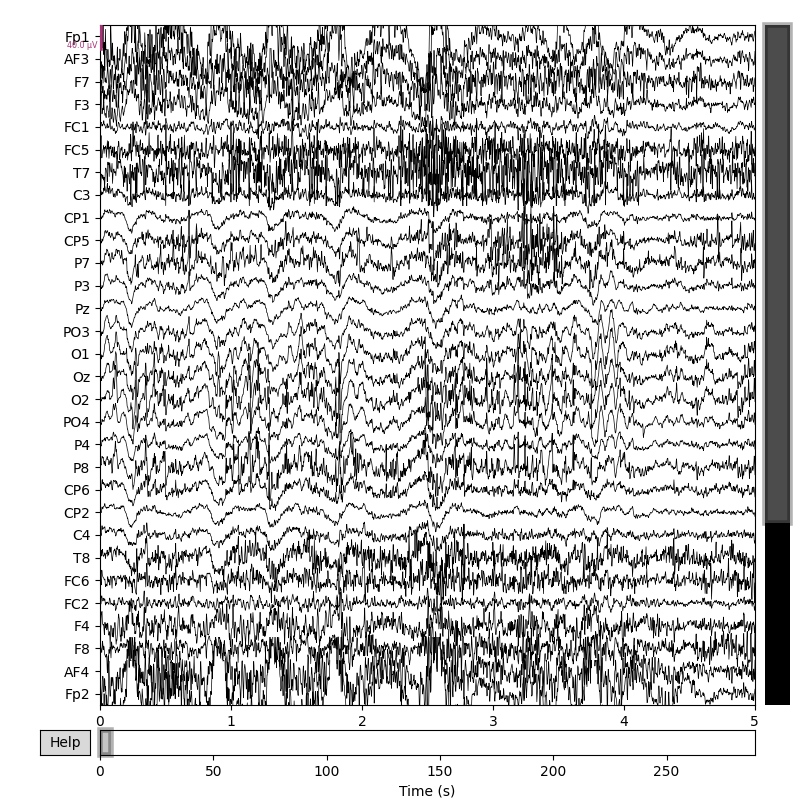

In [11]:
_ = raw_on.plot(duration=5, n_channels=30)

### Preprocessing 1/2

We drop a number of channels from the recording not needed for further analysis.

In [12]:
_ = raw_on.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4','EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status'])

Measurement date,"April 22, 2020 23:50:12 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,32 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,256.00 Hz


Set the correct headset montage details, specify the model mentioned by George et al. in "Dopaminergic therapy in Parkinson's disease decreases cortical beta band coherence in the resting state and increases cortical beta band power during executive control"

In [13]:
_ = raw_on.set_montage("biosemi32", verbose=verbose)

Create a new virtual electrode by averaging all channels, the re-reference the data according to this new virtual reference.

In [14]:
_ = raw_on.set_eeg_reference(ref_channels='average',verbose=verbose)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Apply a high-pass filter with 0.5Hz cut-off frequency

In [15]:
_ = raw_on.filter(0.5, None, fir_design='firwin', phase='zero-double', verbose=verbose)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


#### PSD (optional)

Now that montage data has been added, we can visualize the Power Spectral Density of the `raw_on` stream

Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


/home/codespace/.local/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


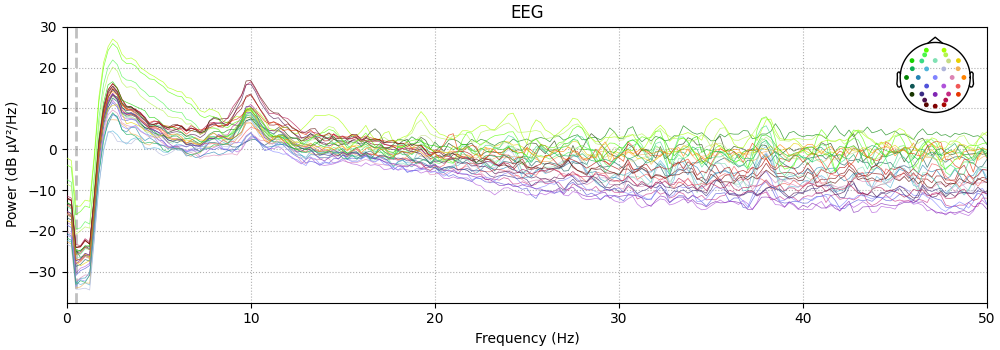

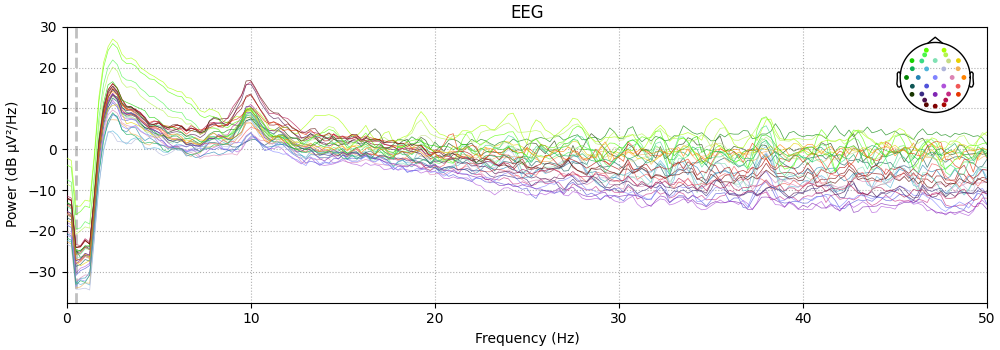

In [16]:
_ = raw_on.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)

### Preprocessing 2/2

Divide the current raw stream in equal epochs of 3sec length.

In [17]:
epochs_all_on = mne.make_fixed_length_epochs(raw_on, duration=3, preload=True, verbose=verbose)

Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 96 events and 1536 original time points ...
0 bad epochs dropped


Apply the default autoreject filter

In [18]:
ar = autoreject.AutoReject(n_interpolate=[1, 2, 3, 4], random_state=11, verbose=verbose)
ar.fit(epochs_all_on)
epochs_on = ar.transform(epochs_all_on)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/96 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/96 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/96 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/96 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/96 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=4


  0%|          | Repairing epochs : 0/96 [00:00<?,       ?it/s]

Dropped 13 epochs: 0, 2, 10, 11, 12, 14, 15, 16, 25, 27, 28, 93, 94


### Calculating PAC

Create a 3-element array for holding the Comodulogram objects, for electrode C3, C4 and their average respectively.

In [19]:
pacs_on = [ PACSettings.create_Comodulogram(raw_on.info['sfreq']) for _ in range(3)]

/home/codespace/.local/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


Fit C3 data to the first element of the array.

In [20]:
pacs_on[0].fit(epochs_on.get_data(picks=['C3'])[:,0,:])

[........................................] 100% | 22.03 sec | comodulogram: DAR(10, 1) 
[........................................] 100% | 22.03 sec | comodulogram: DAR(10, 1) 

C4 data to the second element of the array

In [21]:
pacs_on[1].fit(epochs_on.get_data(picks=['C4'])[:,0,:])

[........................................] 100% | 21.12 sec | comodulogram: DAR(10, 1) 
[........................................] 100% | 21.12 sec | comodulogram: DAR(10, 1) 

Average of both in the third element.

In [22]:
pacs_on[2].comod_ = np.mean([pacs_on[0].comod_, pacs_on[1].comod_],axis=0)

Now that we have calculated the results for on-session, repeat for off-session.

In [23]:
raw_off = fetch_raw(subject, 'off')

raw_off.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4','EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status'])
raw_off.set_montage("biosemi32", verbose=verbose)
raw_off.set_eeg_reference(ref_channels='average',verbose=verbose)
raw_off.filter(0.5, None, fir_design='firwin', phase='zero-double', verbose=verbose)

epochs_all_off = mne.make_fixed_length_epochs(raw_off, duration=3, preload=True, verbose=verbose)
ar = autoreject.AutoReject(n_interpolate=[1, 2, 3, 4], random_state=11, verbose=verbose)
ar.fit(epochs_all_off)
epochs_off = ar.transform(epochs_all_off)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds002778 …


📁 Traversing directories for ds002778 : 0 entities [00:00, ? entities/s]

📥 Retrieving up to 19 files (5 concurrent downloads). 
✅ Finished downloading ds002778.
 
🧠 Please enjoy your brains.
 
Extracting EDF parameters from /tmp/mne/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97791  =      0.000 ...   190.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Filter length: 3381 samples (6.604 s)

Not setting metadata
63 matching events found
No baseline cor

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/63 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/63 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/63 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/63 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/63 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/63 [00:00<?,       ?it/s]

Dropped 4 epochs: 0, 12, 31, 34


Combine the OFF results in another 3-element array.

In [24]:
pacs_off = [ PACSettings.create_Comodulogram(raw_off.info['sfreq']) for _ in range(3)]

pacs_off[0].fit(epochs_off.get_data(picks=['C3'])[:,0,:])
pacs_off[1].fit(epochs_off.get_data(picks=['C4'])[:,0,:])
pacs_off[2].comod_ = np.mean([pacs_off[0].comod_, pacs_off[1].comod_],axis=0)

Skipping participants.json: already downloaded.: 100%|##########| 1.24k/1.24k [00:00<?, ?B/s]

[........................................] 100% | 15.25 sec | comodulogram: DAR(10, 1) 
[........................................] 100% | 15.37 sec | comodulogram: DAR(10, 1) 
[........................................] 100% | 15.37 sec | comodulogram: DAR(10, 1) 

To set a common scale for the Comodulograms, we need to find the Vmax in all results.

In [25]:
vmax = max([pac.comod_.max() for pac in np.concatenate((pacs_on, pacs_off))])

🔄 Request timed out while downloading /tmp/mne/sub-pd6/ses-on/eeg/sub-pd6_ses-on_task-rest_channels.tsv, retrying in 0.5 sec …
🔄 Request timed out while downloading /tmp/mne/sub-pd6/ses-on/eeg/sub-pd6_ses-on_task-rest_eeg.bdf, retrying in 0.5 sec …


Calculate the Modulation Index (MI) for every PAC by averaging the results.

In [26]:
mis_on  = [ np.mean(pac.comod_) for pac in pacs_on ]
mis_off = [ np.mean(pac.comod_) for pac in pacs_off ]

### Results

Print the MI values

In [27]:
print("%s " % (subject))
print(" ON  C3:%.3E C4:%.3E AVG:%.3E" % (mis_on[0], mis_on[1], mis_on[2]))
print(" OFF C3:%.3E C4:%.3E AVG:%.3E" % (mis_off[0], mis_off[1], mis_off[2]))

pd6 
 ON  C3:1.117E-05 C4:7.314E-06 AVG:9.241E-06
 OFF C3:3.286E-05 C4:2.764E-04 AVG:1.547E-04


Create Matplotlib object with the desired structure and size and plot the previously calculated results to it:

/home/codespace/.local/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


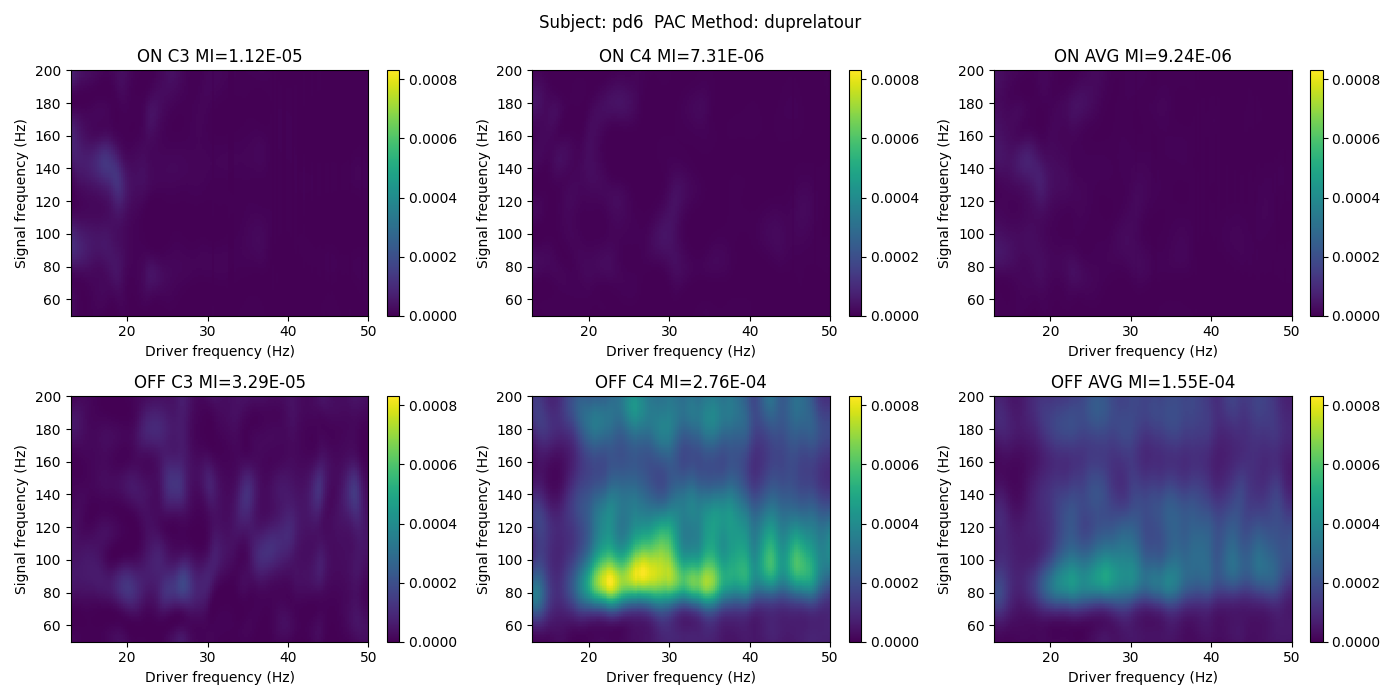

In [28]:
fig,axs=plt.subplots(2,3,figsize=(14,7))

_ = plt.suptitle("Subject: %s  PAC Method: %s"
             % (subject, PACSettings.method ))

pacs_on[0].plot(titles=["ON C3 MI=%.2E"  % mis_on[0]], axs=[axs[0,0]], vmin=0, vmax=vmax)
pacs_on[1].plot(titles=["ON C4 MI=%.2E"  % mis_on[1]], axs=[axs[0,1]], vmin=0, vmax=vmax)
pacs_on[2].plot(titles=["ON AVG MI=%.2E" % mis_on[2]], axs=[axs[0,2]], vmin=0, vmax=vmax)

pacs_off[0].plot(titles=["OFF C3 MI=%.2E"  % mis_off[0]], axs=[axs[1,0]], vmin=0, vmax=vmax)
pacs_off[1].plot(titles=["OFF C4 MI=%.2E"  % mis_off[1]], axs=[axs[1,1]], vmin=0, vmax=vmax)
pacs_off[2].plot(titles=["OFF AVG MI=%.2E" % mis_off[2]], axs=[axs[1,2]], vmin=0, vmax=vmax)
plt.show()
